說明：將探空資料，內差到固定間距的網格上(每五公尺)，再畫等高線。

note: 連續的七天若超過月底，要修改程式!

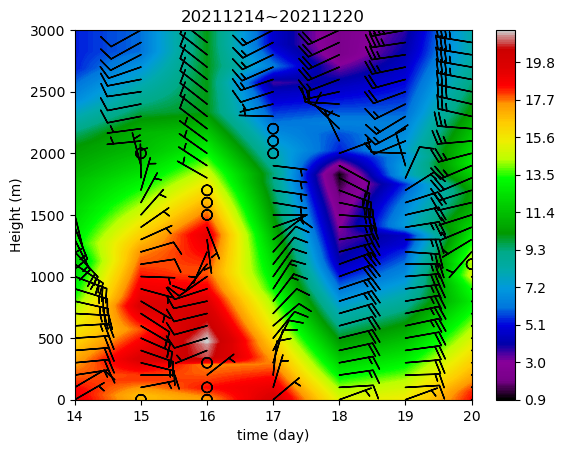

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

#參數
daytime=7 				#時間
level_wind=30				#風的層數
HH =3000 				#高度
level=600				#資料層
DD = 14                 #起始日期

#讀資料
df=pd.read_csv('./202112_upair.txt',sep='\s+',header=11)  
df=df[1:]
df['yyyymmddhh']=df['yyyymmddhh'].astype('int').astype('str')   #換為整數再換為字串

p = []
t = []
h = []
ws =[]
wd =[]
U=[]    #原來的風場
V=[]


U_int = [] #內插的風場
V_int = [] 
T_int = [] #內差的溫度


#內插的網格
x=np.linspace(DD,DD+daytime-1,7)	# x  	= [14 15 16 17 18 19 20]     #日期
y5=np.linspace(0,HH,level+1)		# y5 	= [0 5 10  ...  2995 3000] 
y100=np.linspace(0,HH,level_wind+1)	# y100  = [0 100 200  ...  2900 3000] #每100m畫一筆風場

#========設定變數==========
for i in range(0,daytime):
    #print(i)
    FT=(df['stno']=='466920')&(df['yyyymmddhh']=='202112'+str(DD+i)+'00')&(df['Heigh']<HH)&(df['Ws']<990) 	#設定條件
    
    PT= df.loc[FT,'Press']								
    TT= df.loc[FT,'Tx']    
    HT= df.loc[FT,'Heigh']
    WST=df.loc[FT,'Ws']
    WDT=df.loc[FT,'Wd']

    p=p+[PT]    # p為list，為p[0]~p[6]
    t=t+[TT]
    h=h+[HT]
    ws=ws+[WST]
    wd=wd+[WDT]

    uu = [-spd*1.943844*math.sin(math.radians(agl)) for spd,agl in zip(ws[i],wd[i])]
    vv = [-spd*1.943844*math.cos(math.radians(agl)) for spd,agl in zip(ws[i],wd[i])]
    U=U+[uu]        #unit:knot
    V=V+[vv]    
#print(U[0]) #unit:knot

#內插
    UU_int = np.interp(y5,h[i],U[i])
    VV_int = np.interp(y5,h[i],V[i])
    TT_int = np.interp(y5,h[i],t[i])
    U_int = U_int+ [UU_int]
    V_int = V_int+ [VV_int]
    T_int = T_int+ [TT_int]   


#串接起來
t_con=np.concatenate([T_int[0],T_int[1],T_int[2],T_int[3],T_int[4],T_int[5],T_int[6]])
U_con=np.concatenate([U_int[0],U_int[1],U_int[2],U_int[3],U_int[4],U_int[5],U_int[6]])
V_con=np.concatenate([V_int[0],V_int[1],V_int[2],V_int[3],V_int[4],V_int[5],V_int[6]])

#print(len(t1_inter))				
#print(len(t))				
#重新分配為contourf可以接受的矩陣			
t_con=np.reshape(t_con,(daytime,level+1)).T
u_con=np.reshape(U_con,(daytime,level+1)).T
v_con=np.reshape(V_con,(daytime,level+1)).T


#==========將網格風場每100m取點==========
Vf,Uf=[],[]
for i in range(0,level_wind+1):         #level_wind=30 (此處i=0~30)
  Uf.append(u_con[i*20])
  Vf.append(v_con[i*20])

#========================================

plt.contourf(x,y5,t_con,cmap='nipy_spectral',levels=500)   	#使用所有的顏色
plt.barbs(x,y100,Uf,Vf)
plt.title("20211214~20211220")
plt.xlabel('time (day)')
plt.ylabel('Height (m)')
plt.colorbar()						#繪製colorbar
plt.show()



/Users/linchunho/opt/miniconda3/envs/py38/lib/python3.8/site-packages/metpy/calc/thermo.py:1194: UserWarning: Duplicate pressure(s) [47.7] hPa provided. Output profile includes duplicate temperatures as a result.
  warnings.warn(f'Duplicate pressure(s) {unique[counts > 1]:~P} provided. '


CAPE 0 joule / kilogram
CIN 0 joule / kilogram
K-index 5.6 degree_Celsius


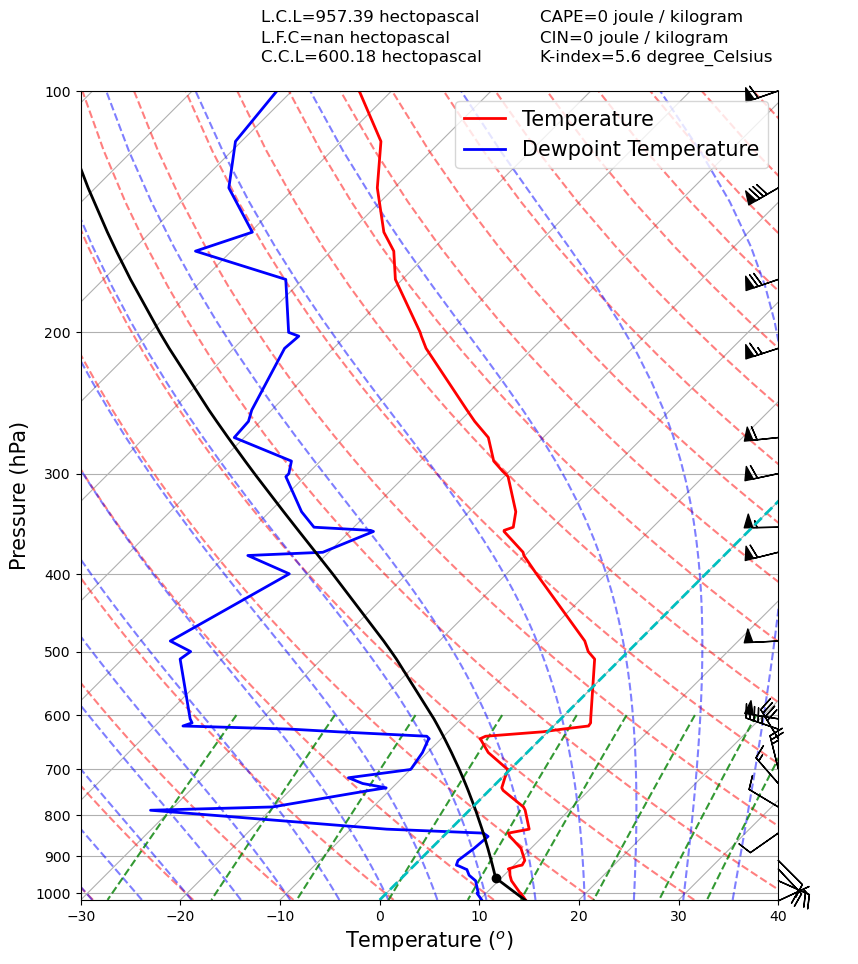

In [2]:
#!/usr/bin/env python
#探空圖繪製參考
#https://unidata.github.io/MetPy/latest/examples/Advanced_Sounding.html#sphx-glr-download-examples-advanced-sounding-py
#CIN、CAPE
#https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.cape_cin.html
#K-index
#https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.k_index.html#metpy.calc.k_index

# In[1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units
from metpy.calc import lcl , lfc
#from metpy.calc import lfc



df=pd.read_csv('./202101_upair.txt',sep='\s+',header=11)
#df=pd.read_csv('C:/Users/路徑.../202101_upair.txt',sep='\s+',header=11)
df=df[1:]

df['yyyymmddhh']=df['yyyymmddhh'].astype('int').astype('str')

filt=(df['stno']=='466920')&(df['yyyymmddhh']=='2021013000')  


# In[3]:

p=df.loc[filt,'Press'].values * units.hPa
T=df.loc[filt,'Tx'].values * units.degC
Td=df.loc[filt,'Td'].values * units.degC
rh=df.loc[filt,'RH'].values

wind_speed = df.loc[filt,'Ws'].values * units.knots *1.94384449                         #note:unit
wind_dir = df.loc[filt,'Wd'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)


# In[4]:

fig = plt.figure(figsize=(9,11))

#add_metpy_logo(fig, 120, 50)
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.

skew.plot(p, T, 'r', lw=2, label='Temperature')
skew.plot(p, Td, 'b', lw=2, label='Dewpoint Temperature')
skew.plot_barbs(p[::3], u[::3], v[::3], y_clip_radius=0.03)  #[::3] 每3點取資料
skew.ax.set_ylim(1020, 100)
skew.ax.set_xlim(-30, 40)


# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])          #LCL     
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof, Td)
skew.shade_cape(p, T, prof)

#計算CAPE CIN K-index
CAPE,CIN= mpcalc.cape_cin(p, T, Td, prof)                                           #計算CAPE & CIN & K-index
K=mpcalc.k_index(p, T, Td)
print("CAPE",CAPE)
print("CIN",CIN)
print("K-index",K)

#計算LFC、CCL
ccl_p, ccl_t, t_c = mpcalc.ccl(p, T, Td)                                #CCL
lfc_p, lfc_t = lfc(p, T, Td)


# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
#skew.plot_dry_adiabats()
#skew.plot_moist_adiabats()
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10)*units.K, alpha=0.5, color='orange')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5)*units.K, alpha=0.5, color='g')
skew.plot_mixing_lines()

# Show the plot

CAPE='CAPE=' + str(round(CAPE,2))
CIN = 'CIN=' + str(round(CIN,2))
K = 'K-index=' + str(round(K,1))
CCL = 'C.C.L=' + str(round(ccl_p,2))
LCL = 'L.C.L=' + str(round(lcl_pressure,2))
LFC = 'L.F.C=' + str(round(lfc_p,2))


plt.text(-72,82,CAPE,fontsize=12)
plt.text(-70,87,CIN,fontsize=12)    
plt.text(-68,92,K,fontsize=12)
plt.text(-100,82,LCL,fontsize=12)
plt.text(-98,87,LFC,fontsize=12)
plt.text(-96,92,CCL,fontsize=12)

plt.xlabel("Temperature ($^o$)", fontsize=15)  #$^o$ 上標符號'度'
plt.ylabel("Pressure (hPa)", fontsize=15)
plt.legend(loc='upper right', fontsize=15)

plt.show()







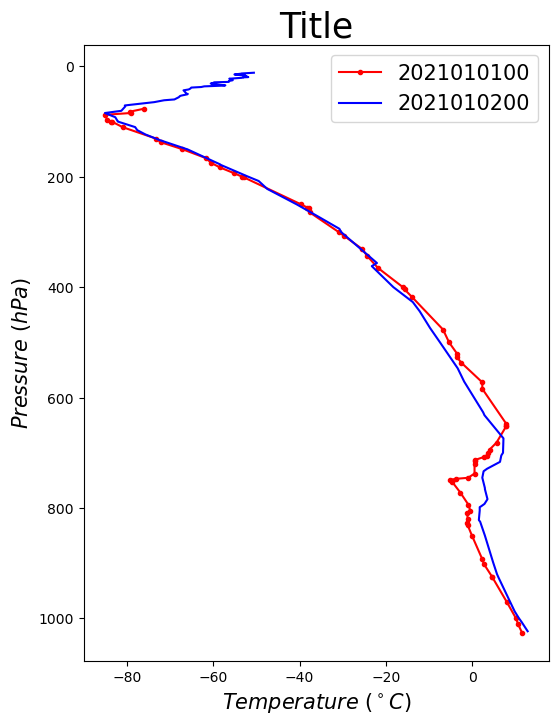

In [3]:
#===========套件===========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#==========讀資料==========
df=pd.read_csv('./202101_upair.txt',sep='\s+',header=11)   #讀資料,
df=df[1:]
df['yyyymmddhh']=df['yyyymmddhh'].astype('int').astype('str')   #換為整數再換為字串
#print(df['yyyymmddhh'])

#設定條件，只讀取單一測站單一時間的資料。
filt=(df['stno']=='466920')&(df['yyyymmddhh']=='2021010100')
#取出列名相對應的資料。
p1=df.loc[filt,'Press']
t1=df.loc[filt,'Tx']    
h1=df.loc[filt,'Heigh']

filt=(df['stno']=='466920')&(df['yyyymmddhh']=='2021010200')  
p2=df.loc[filt,'Press']
t2=df.loc[filt,'Tx']
h2=df.loc[filt,'Heigh']


#==========繪圖==========
plt.figure(figsize=(6,8))       #繪圖區域長寬比、解析度
plt.plot(t1,p1,'r.-',label="2021010100")	#繪製函數圖
plt.plot(t2,p2,'b-',label="2021010200")


plt.gca().invert_yaxis()                #將y軸反轉，壓力從(0~1000)變成(1000~0)
plt.xlabel('$Temperature\ (^\circ C)$',fontsize=15)	#X軸名稱
plt.ylabel('$Pressure\ (hPa)$',fontsize=15)		#Y軸名稱
plt.title("Title",fontsize=25)		
plt.legend(loc='upper right', fontsize=15)
#plt.grid()   				#設置網格線
plt.show()


